In [421]:
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Load Data

In [326]:
X = np.load("X_feat_mat.npy")
y = np.load("y_label_vect.npy")

In [328]:
print('X.shape={}, y.shape={}'.format(X.shape, y.shape))

X.shape=(102, 12), y.shape=(102,)


### Normalize Data

In [329]:
# Shift to zero mean and normalize y
y = y-1
y

array([ 0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.])

In [335]:
# Normalize X
X = normalize(X)
X.shape

(102, 12)

### Dimensionality Reduction

In [366]:
# Parameter
var_desired = 0.99
# PCA
pca = PCA(n_components=X.shape[1]-1)
pca.fit(X)
 
var_sum = pca.explained_variance_ratio_.sum()
print('pca.explained_variance_ratio_',pca.explained_variance_ratio_)
var = 0
for n, v in enumerate(pca.explained_variance_ratio_):
    var += v
    if var / var_sum >= var_desired:
        print(var/var_sum)
        pca_trans = PCA(n_components=n+1)
        X_pca = pca_trans.fit_transform(X)
        break
        
X_pca.shape

pca.explained_variance_ratio_ [  4.87063266e-01   2.31327059e-01   1.58861805e-01   6.81664398e-02
   2.19083684e-02   2.05409751e-02   6.63973057e-03   3.09107346e-03
   1.85995029e-03   3.13683105e-04   1.30012900e-04]
0.994604753461


(102, 7)

### Split Data

In [425]:
split_n = 90
X_train, X_test = X_pca[:split_n], X_pca[split_n:]
y_train, y_test = y[:split_n], y[split_n:]

### Plot data

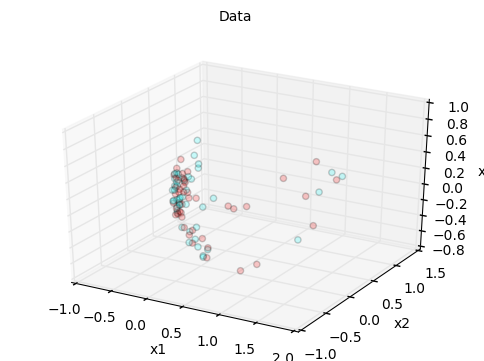

In [379]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

if X_train.shape[1] != 3:
    # PCA 
    pca_3comp = PCA(n_components=3)
    X_3comp = pca_3comp.fit_transform(X)
    
# Plot
colors_data = ['red','cyan']
fig = plt.figure()
fig.suptitle('Data')
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X_train.T[0], X_train.T[1], X_train.T[2], alpha=0.2,
           c=y_train, cmap=mpl.colors.ListedColormap(colors_data))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

# Classifier

In [380]:
# Print results of classifier
def results(y, y_):
    # Results
    n_mclf = len(np.nonzero(y-y_)[0])
    rate_mclf = n_mclf / len(y)
    print('Misclassifications = {} from {} total samples. MCLF Rate = {}'.format(
        n_mclf, len(y), rate_mclf))

## - SciKit Random Forest

In [386]:
from sklearn.ensemble import RandomForestClassifier

In [405]:
clf_rf = RandomForestClassifier(n_estimators=100000)
clf_rf.fit(X_train, y_train)

# Prediction
y_ = clf_rf.predict(X_test)
results(y_test, y_)

Misclassifications = 7 from 12 total samples. MCLF Rate = 0.5833333333333334


## - SciKit Logistic Regression

In [392]:
from sklearn.linear_model import LogisticRegression

In [420]:
# Train
clf_lr = LogisticRegression(C=100)
clf_lr.fit(X_train, y_train)
# Predict
y_ = clf_lr.predict(X_test)
results(y_test, y_)

Misclassifications = 8 from 12 total samples. MCLF Rate = 0.6666666666666666


# - MLP Tensorflow

In [422]:
import tensorflow as tf

In [470]:
def MLP(X_train, X_test, Y_train, Y_test):
    # Computing Parameter
    NUM_THREADS = 10
    # Visualization Parameter
    display_step = 1
    # Learning Parameters
    learning_rate = 0.1
    training_epochs = 100
    dropout_rate = 0.5
    converg_thresh = 0.001     # threshold of improvement between accuracy of last 2 epochs
    total_len = X_train.shape[0]
    # Network Parameters
    n_input = X_train.shape[1]
    n_hidden_1 = 10    # 1st layer number of features
    n_hidden_2 = 1     # 2nd layer number of features
    n_output = Y_train.shape[1]
    

    # Create nodes for the input data and target output classes
    x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]]) # first dimension not fixed (depends on batch size)
    y = tf.placeholder(tf.float32, shape=[None, Y_train.shape[1]])    
    # Dropout
    keep_prob = tf.placeholder(tf.float32)

    # Create model
    def multilayer_perceptron(x, weights, biases):
        # 1. Hidden layer
        layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
        layer_1 = tf.tanh(layer_1) 
        # 2. Hidden layer
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.tanh(layer_2)
        # Output layer with linear activation
        layer_out = tf.add(tf.matmul(layer_2, weights['w_out']), biases['b_out'])
        layer_out = tf.sigmoid(layer_out)
        return layer_out

    # Store layers weight & bias
    weights = { 
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1], 0, 0.1)),
        'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], 0, 0.1)),
        'w_out': tf.Variable(tf.random_normal([n_hidden_2, n_output], 0, 0.1))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1], 0, 0.1)),
        'b2': tf.Variable(tf.random_normal([n_hidden_2], 0, 0.1)),
        'b_out': tf.Variable(tf.random_normal([n_output], 0, 0.1))
    }

    # Construct model
    y_pred = multilayer_perceptron(x, weights, biases)
    # Define loss and optimizer
    #cost = tf.reduce_mean(tf.square(tf.transpose(y_pred)-y))
    cost = tf.reduce_mean(tf.square(y_pred-y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    #
    # Train and Evaluate the Model
    #
    
    # Start interactive session
    sess = tf.InteractiveSession(config=tf.ConfigProto(intra_op_parallelism_threads=NUM_THREADS))

    # loss function
    correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
    # result
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # start sesseion
    sess.run(tf.global_variables_initializer())
    # training
    train_accuracy_list = [0]
    t0 = time.time()
    
    for epoch in range(training_epochs):
        # Train
        optimizer.run(feed_dict={x:X_train, y:Y_train, keep_prob:dropout_rate})
        # Show update 
        if epoch % display_step == 0:
            train_accuracy_list.append(accuracy.eval(feed_dict={x:X_train, y:Y_train, keep_prob:1.0}))
            improvement = abs(train_accuracy_list[-2] - train_accuracy_list[-1])
            print("Epoch %d, training accuracy %g, improvement %.5f (%.0f sec)"%(
                    epoch, train_accuracy_list[-1], improvement, time.time()-t0))
            t0 = time.time()
            # Check if converged
            if train_accuracy_list[-1] == 1 or improvement <= converg_thresh:
                print("Converged!")
                break

    print("Test accuracy %g"%accuracy.eval(
            feed_dict={x: X_test, y: Y_test, keep_prob: 1.0}))

In [471]:
# Train MLP
MLP(X_train, X_test, y_train.reshape(-1,1), y_test.reshape(-1,1))

Epoch 0, training accuracy 1, improvement 1.00000 (0 sec)
Converged!
Test accuracy 1


True